<a href="https://colab.research.google.com/github/eltongaspar/advpl/blob/Advpl/6_4_Reconhecimento_de_Emocoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Mounted at /content/gdrive


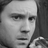

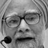

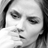

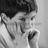

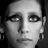

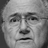

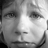

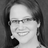

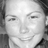

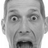

In [ ]:
#Estudo de caso
#Reconhecimento de Emoções

#Importando as bibliotecas
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

#Conectando com o Drive e acessando os arquivos
# Conectando o Colab ao Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Realize o dowload da pasta Material_complementar_reconhecimento_emocoes.zip do Google Sala de Aula e transfira-a para o seu Google Drive
# Localize o caminho da pasta no menu Arquivos, no menu lateral esquerdo
path = "/content/gdrive/MyDrive/Classroom/Inteligência Artificial aplicada à Visão Computacional Turma 99 - 6: 01 02 a 31 05 2024/6-4/Material_complementar_reconhecimento_emocoes.zip"
#print(path)
#import os
#file_exists = os.path.isfile(path)
#print(file_exists)
#zip_object = zipfile.ZipFile(file=path, mode="r")
#zip_object.extractall("./")

# Indique o caminho da pasta "fer2013.zip" para descompactá-la. São arquivos organizados conforme cada uma das classes de emoções.
base_imgs = '/content/gdrive/MyDrive/Classroom/Inteligência Artificial aplicada à Visão Computacional Turma 99 - 6: 01 02 a 31 05 2024/6-4/Material_complementar_reconhecimento_emocoes/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = 'r')
zip_object.extractall('./')
#zip_object.close

#Acessando a base com fotos de expressões faciais
# Arquivo que contem as informações do banco de imagens das fotos de cada classe de emoção.
data = pd.read_csv('fer2013/fer2013.csv')
data.tail()

# Visualizando a quantidade de fotos existente em cada uma das classes de emoções.
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins = 30)
plt.title('Imagens x emoções')

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#Pré-processamento

# Listando os valores de pixels das imagens
pixels = data['pixels'].tolist()

# Redimensionando as imagens encontradas
largura, altura = 48, 48
faces = []
amostras = 0
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura)
  faces.append(face)

  if (amostras < 10): # demonstrando um conjunto de 10 amostras
    cv2_imshow(face)
  amostras += 1

  # Demonstrando a quantidade total de imagens em que foram encontradas faces.
print('Número total de imagens no dataset: ', str(len(faces)))

# Convertendo as faces das imagens em arrays
faces = np.asarray(faces)

# Demonstrando as formas das faces das imagens (quantidade, pixels x, pixels y)
faces.shape

# Expandindo as dimensões das faces das imagens (quantidade, pixels x, pixels y, quantidade de canais)
faces = np.expand_dims(faces, -1)
faces.shape

# Definindo a função para normalizar as imagens
def normalizar(x):
  x = x.astype('float32')
  x = x / 255.0
  return x

  # Normalizando as imagens das faces
faces = normalizar(faces)

# Atribuindo valores a cada uma das classes de emoções
emocoes = pd.get_dummies(data['emotion']).values

#Imports do Tensorflow/Keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json


#Dividir em conjuntos para treinamento e validação
# Criando os conjuntos de treinamento e validação
X_train, X_test, y_train, y_test = train_test_split(faces, emocoes, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 41)

# Quantidade das imagens dos conjuntos
print('Número de imagens no conjunto de treinamento:', len(X_train))
print('Número de imagens no conjunto de teste:', len(X_test))
print('Número de imagens no conjunto de validação:', len(X_val))

# Base de dados para a matriz de confusão
np.save('mod_xtest', X_test)
np.save('mod_ytest', y_test)

#Arquitetura do modelo da rede neural convolucional (CNN)
#Arquitetura do modelo
# Criando o modelo sequencial da rede neural, trazendo cada uma das camadas.
num_features = 64
num_labels = 7
batch_size = 64
epochs = 50
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

#Compilando o modelo
model.compile(loss = 'categorical_crossentropy', # Classificação - cálculo dos erros
              optimizer = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), # Atualização dos pesos / taxa decaimento e taxa aprendizagem
              metrics = ['accuracy'])

arquivo_modelo = 'modelo_01_expressoes.h5' # Traz os modelos salvos - com o conjunto dos pesos de aprendizado da rede neural
arquivo_modelo_json = 'modelo_01_expressoes.json' # Traz a estrutura da rede neural

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)



#Salvando a arquitetura do modelo em um arquivo JSON
model_json = model.to_json()
with open(arquivo_modelo_json, 'w') as json_file:
  json_file.write(model_json)

#Treinando o modelo
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = batch_size, #64
                    epochs = epochs, #100
                    verbose = 1,
                    validation_data = (np.array(X_val), np.array(y_val)),
                    shuffle=True,
                    callbacks=[lr_reducer, early_stopper, checkpointer])

#Gerando gráfico da melhora em cada etapa do treinamento
def plota_historico_modelo(historico_modelo):
  fig, axs = plt.subplots(1, 2, figsize=(15,5))
  axs[0].plot(range(1, len(historico_modelo.history['accuracy']) + 1), historico_modelo.history['accuracy'], 'r')
  axs[0].plot(range(1, len(historico_modelo.history['val_accuracy']) + 1), historico_modelo.history['val_accuracy'], 'b')
  axs[0].set_title('Acurácia do modelo')
  axs[0].set_ylabel('Acurácia')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['training accuracy', 'validation accuracy'], loc = 'best')
  axs[1].plot(range(1, len(historico_modelo.history['loss']) + 1), historico_modelo.history['loss'], 'r')
  axs[1].plot(range(1, len(historico_modelo.history['val_loss']) + 1), historico_modelo.history['val_loss'], 'b')
  axs[1].set_title('Loss do modelo')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['training loss', 'validation loss'], loc = 'best')
  fig.savefig('historico_modelo_mod01.png')

plota_historico_modelo(history)

#Verificando a acurácia do modelo
# Relação do erro x acurárcia
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size = batch_size) #
scores

print('Acurácia: ' + str(scores[1]))
print('Erro: ' + str(scores[0]))


#Carregamento dos dados para gerar a matriz de confusão
# Valores reais e das predições
true_y = []
pred_y = []
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')

# Carregar o modelo salvo com a estrutura da rede neural
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()

# Predição dos pixels de cada uma das imagens para cada uma das emoções
y_pred = loaded_model.predict(x)

# Transformar as predições em uma lista
yp = y_pred.tolist()
yt = y.tolist() # com as respostas reais
count = 0

# Quantidade de registros na base de dados de teste
len(y)

# Obtendo o maior valor da probabilidade
for i in range(len(y)):
  yy = max(yp[i])
  yyt = max(yt[i])
  pred_y.append(yp[i].index(yy))
  true_y.append(yt[i].index(yyt))
  if (yp[i].index(yy) == yt[i].index(yyt)):
    count += 1

acc = (count / len(y)) * 100

# Demonstrar o valor da acurácia
print('Acurácia no conjunto de teste: ' + str(acc))


# Salvar os valores das emoções e predições
np.save('truey_mod01', true_y)
np.save('predy_mod01', pred_y)

#Gerando a Matriz de Confusão
from sklearn.metrics import confusion_matrix

y_true = np.load('truey_mod01.npy')
y_pred = np.load('predy_mod01.npy')

# Matriz de acertos classe por classe
cm = confusion_matrix(y_true, y_pred)
expressoes = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']
titulo = 'Matriz de Confusão'
print(cm)

# Construindo a matriz de confusão
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation = 45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')

plt.ylabel('Classificação correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')

# Localize o arquivo "salagooglemeet.jpg" para realizar o reconhecimento das emoções
imagem = cv2.imread('/content/testes/salagooglemeet.jpg')
cv2_imshow(imagem)

# Transformando a imagem original em escala de cinza
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

# Utilize o arquivo haarcascade de reconhecimento facial para detectar as faces na imagem
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)

# Reconhecendo as emoções nas faces detectadas, criando um retângulo e indicação textual na imagem original.
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 4)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)

